In [1]:
# Install required libs
# !pip install -U segmentation-models-pytorch albumentations

In [2]:
#!pip uninstall -y segmentation-models-pytorch

## Loading data

In [3]:
import os
from glob import glob
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [4]:
DATA_DIR = './data_processed/'

In [5]:
x_files = glob(os.path.join(DATA_DIR, 'images/*'))
y_files = [x.replace('images', 'mask') for x in x_files]

In [ ]:
train_indexes = []
val_indexes = []

for train_index, val_index in KFold(n_splits=5, shuffle=True, random_state=17).split(x_files):
    train_indexes.append(train_index)
    val_indexes.append(val_index)

In [ ]:
FOLD_TO_RUN = 0 # 0-4 include

x_train_files = list(np.array(x_files)[train_indexes[FOLD_TO_RUN]])
x_val_files = list(np.array(x_files)[val_indexes[FOLD_TO_RUN]])
y_train_files = list(np.array(y_files)[train_indexes[FOLD_TO_RUN]])
y_val_files = list(np.array(y_files)[val_indexes[FOLD_TO_RUN]])

In [7]:
x_test_files = glob('test_dataset_test/')

In [8]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [24]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [ ]:
IMAGE_HEIGHT = 576
IMAGE_WIDTH = 1024

# IMAGE_HEIGHT = 288*2
# IMAGE_WIDTH = 288*3

print(IMAGE_HEIGHT, IMAGE_WIDTH)

In [25]:
class Dataset(BaseDataset):
    
    CLASSES = [6, 7, 10]
    
    def __init__(
            self, 
            images_paths, 
            masks_paths, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = [x.split('/')[-1] for x in images_paths]
        self.images_fps = images_paths
        self.masks_fps = masks_paths
        
        # convert str names to class values on masks
        self.class_values = classes
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        image = cv2.resize(image, (YSHAPE, XSHAPE))
        mask = cv2.resize(mask, (YSHAPE, XSHAPE))
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

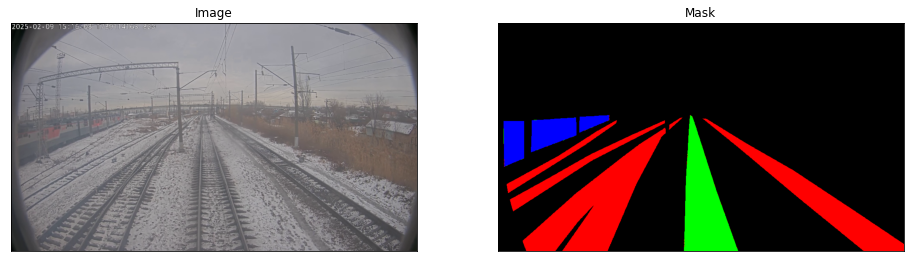

In [26]:
# Lets look at data we have

dataset = Dataset(x_train_files, y_train_files, classes=[6, 7, 10])

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    mask=mask.squeeze(),
)

In [27]:
image.shape

(576, 1024, 3)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [16]:
import albumentations as albu

In [17]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.25, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=0),

        albu.CenterCrop(height=int(np.random.randint(5, 9)/10*IMAGE_HEIGHT), 
                        width=int(np.random.randint(5, 9)/10*IMAGE_WIDTH), p=0.5),
        
        albu.Resize(IMAGE_HEIGHT, IMAGE_WIDTH, p=1),
        albu.PadIfNeeded(min_height=IMAGE_HEIGHT, min_width=IMAGE_WIDTH, always_apply=True, border_mode=0),
        
        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),
        
        albu.ToGray(p=0.2),
#         albu.Cutout(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.5,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=0.5),
                albu.Blur(blur_limit=3, p=0.5),
                albu.MotionBlur(blur_limit=3, p=0.5),
            ],
            p=0.5,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.5,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(IMAGE_HEIGHT, IMAGE_WIDTH)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

/Users/hare/opt/anaconda3/envs/champ/lib/python3.9/site-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
/Users/hare/opt/anaconda3/envs/champ/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/Users/hare/opt/anaconda3/envs/champ/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1639: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


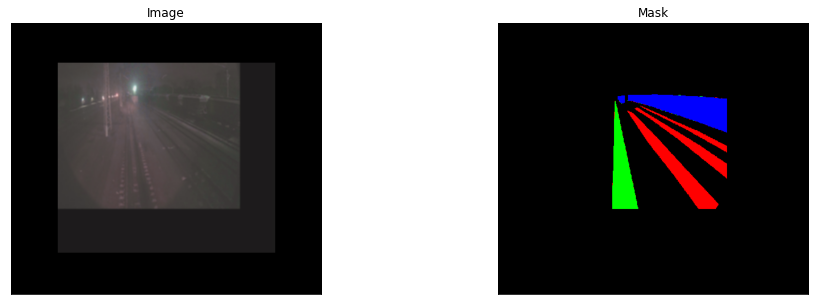

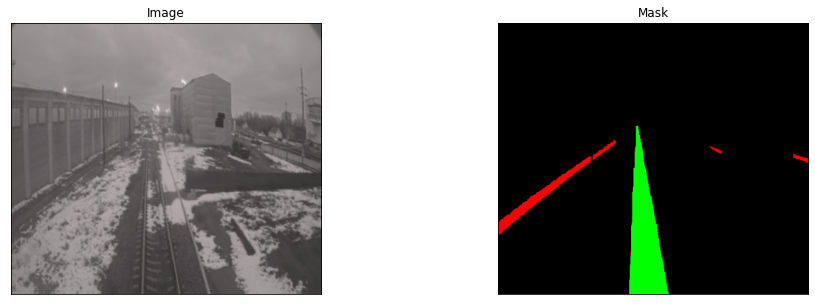

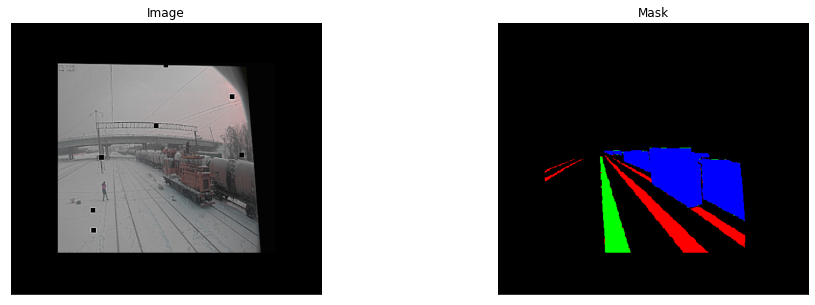

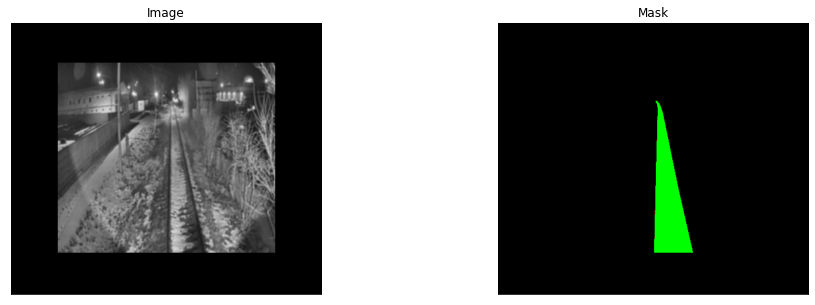

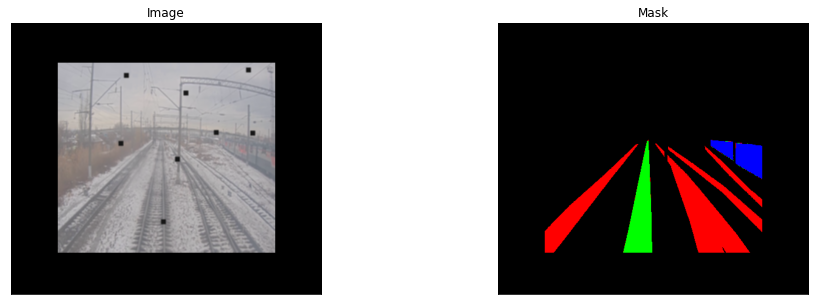

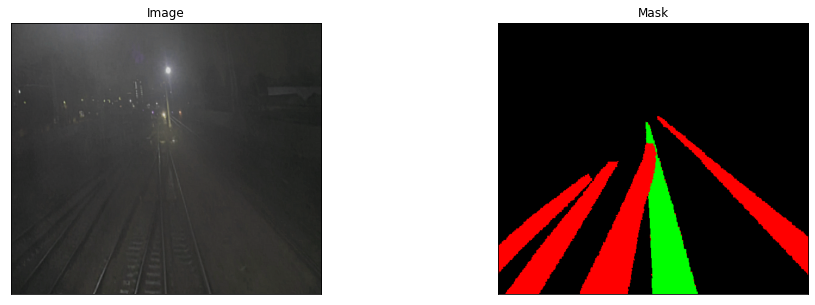

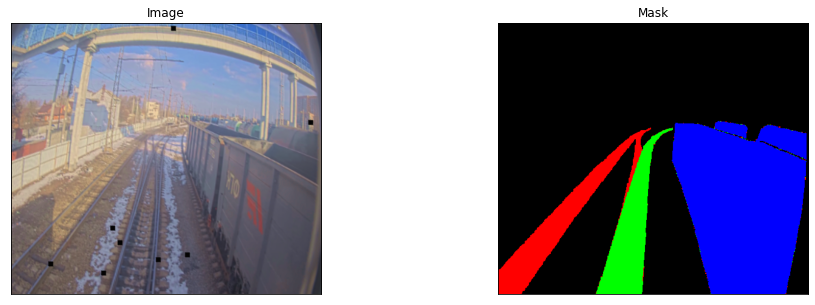

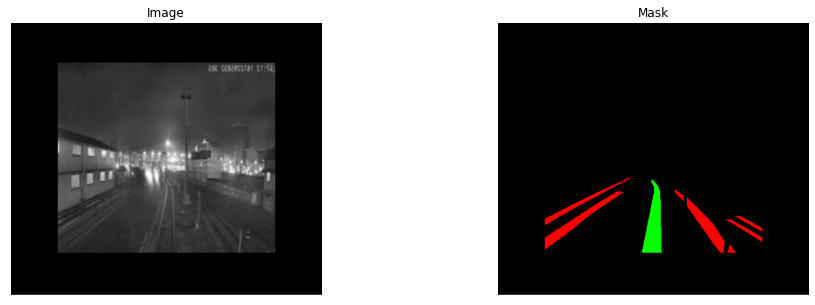

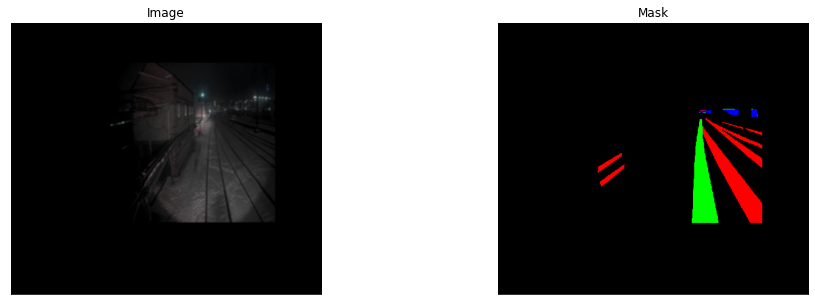

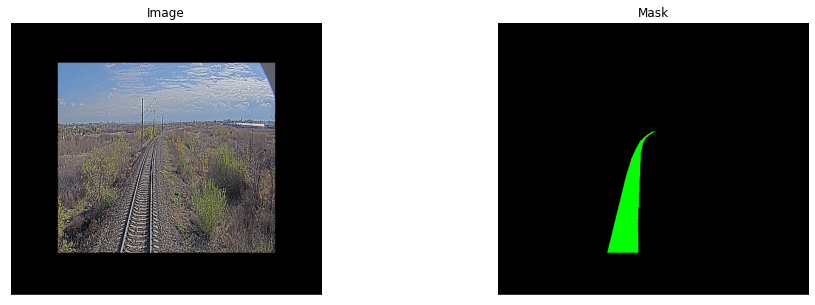

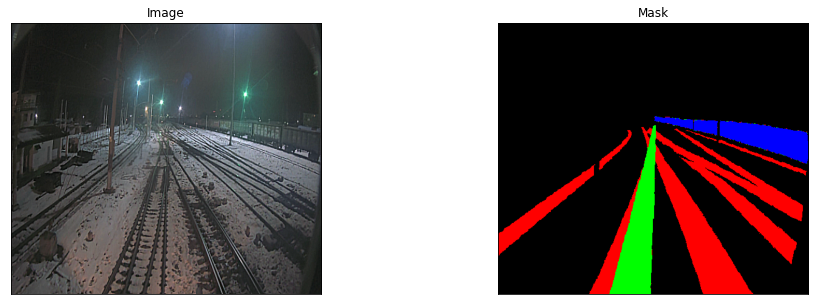

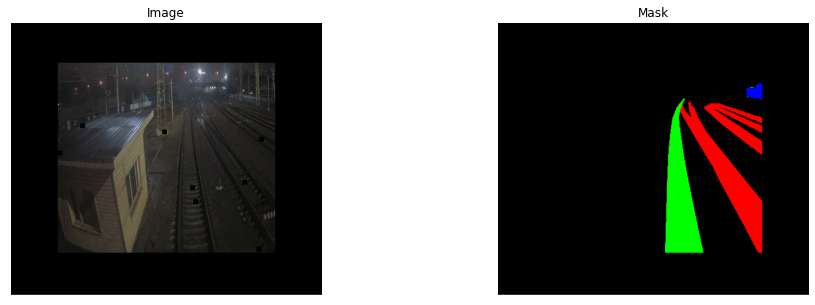

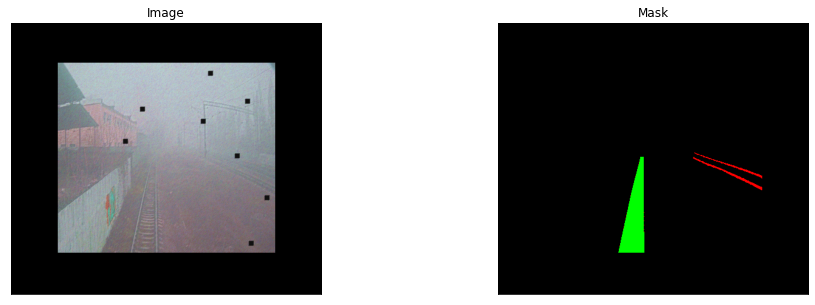

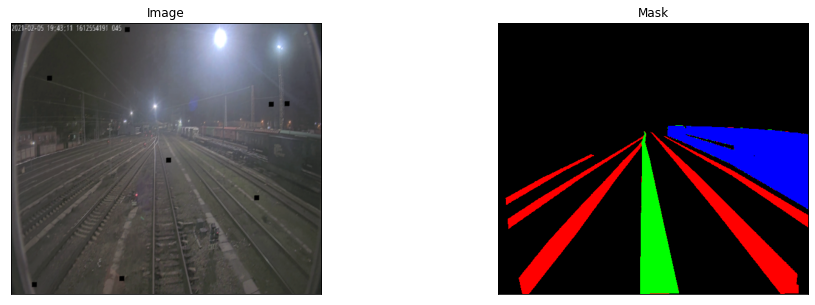

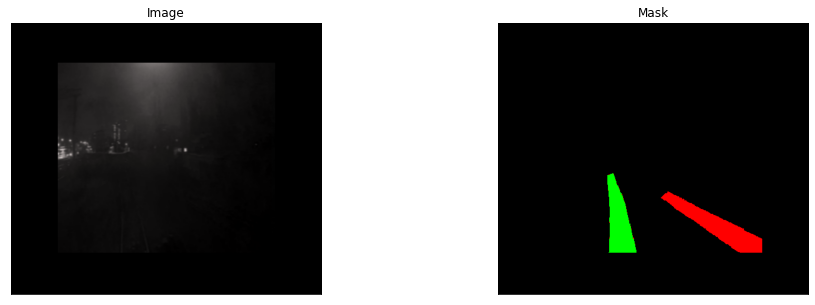

In [18]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_files, 
    y_train_files, 
    augmentation=get_training_augmentation(), 
    classes=[6, 7, 10],
)

# same image with different random transforms
for i in range(1):
    image, mask = augmented_dataset[i]
    visualize(image=image, mask=mask.squeeze())

In [19]:
mask.shape

(448, 512, 3)

## Create model and train

In [20]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [21]:
ENCODER = 'efficientnet-b4'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = [6, 7, 10]
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
import matplotlib.pyplot as plt

EPOCHS = 50
BATCH_SIZE = 4

def get_lr_callback(plot=False):
    lr_start   = 1e-4
    lr_max     = 1e-3
    lr_min     = 1e-6
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        return lr
        
    if plot:
        epochs = list(range(EPOCHS))
        learning_rates = [lrfn(x) for x in epochs]
#         print([f'{i:.20f}' for i in learning_rates])
        plt.scatter(epochs,learning_rates)
        plt.show()

    return learning_rates

LEARNING_RATES = get_lr_callback(plot=True)

In [38]:
import collections

train_dataset = Dataset(
    x_train_files, 
    y_train_files, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_val_files, 
    y_val_files, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)
valid_dataset_vis = Dataset(
    x_val_files, 
    y_val_files, 
    augmentation=get_validation_augmentation(), 
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

/Users/hare/opt/anaconda3/envs/champ/lib/python3.9/site-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
/Users/hare/opt/anaconda3/envs/champ/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/Users/hare/opt/anaconda3/envs/champ/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1639: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [39]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.BCELoss() + smp.utils.losses.DiceLoss()

metrics = [
    smp.utils.metrics.IoU(),
    smp.utils.metrics.Accuracy()
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=LEARNING_RATES[0]),
])

In [40]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
plot_val_pred_n = np.random.choice(len(valid_dataset))

def plot_val_pred():
    
    image, gt_mask = valid_dataset[plot_val_pred_n]
    image_vis = valid_dataset_vis[plot_val_pred_n][0]
    
    gt_mask = gt_mask.squeeze()
    gt_mask_ = np.zeros((gt_mask.shape[1], gt_mask.shape[2], 3))
    gt_mask_[..., 0] = gt_mask[0, ...]
    gt_mask_[..., 1] = gt_mask[1, ...]
    gt_mask_[..., 2] = gt_mask[2, ...]
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
#     x_tensor = torch.from_numpy(image).unsqueeze(0)
    pr_mask = model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    pr_mask_ = np.zeros((pr_mask.shape[1], pr_mask.shape[2], 3))
    pr_mask_[..., 1] = pr_mask[1, ...]
    pr_mask_[..., 0] = pr_mask[0, ...]
    pr_mask_[..., 2] = pr_mask[2, ...]
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask_, 
        predicted_mask=pr_mask_
    )

In [41]:
# train model

max_score = 0

for i in range(0, EPOCHS):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    plot_val_pred()
        
    if i < EPOCHS:
        optimizer.param_groups[0]['lr'] = LEARNING_RATES[i+1]
        print(f'Decrease decoder learning rate to {LEARNING_RATES[i+1]}')


Epoch: 0
train:   0%|                                            | 0/872 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/hare/opt/anaconda3/envs/champ/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/hare/opt/anaconda3/envs/champ/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'Dataset' on <module '__main__' (built-in)>


train:   0%|                                            | 0/872 [00:01<?, ?it/s]


KeyboardInterrupt: 

## Test best saved model

In [54]:
# load best saved checkpoint
best_model = torch.load('./models/best_model-8.pth', map_location=torch.device('cpu'))
best_model.eval()
# 864 576

best_model2 = torch.load('./models/best_model-9.pth', map_location=torch.device('cpu'))
best_model2.eval()
# 1024 576

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        

In [28]:
# create test dataset
test_dataset = Dataset(
    x_val_files, 
    y_val_files, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset, shuffle=False)

In [29]:
# # evaluate model on test set
# test_epoch = smp.utils.train.ValidEpoch(
#     model=best_model,
#     loss=loss,
#     metrics=metrics,
#     # device=DEVICE,
# )

# logs = test_epoch.run(test_dataloader)

## Visualize predictions

In [30]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_val_files, y_val_files, 
    classes=[6, 7, 10],
)

[W NNPACK.cpp:80] Could not initialize NNPACK! Reason: Unsupported hardware.


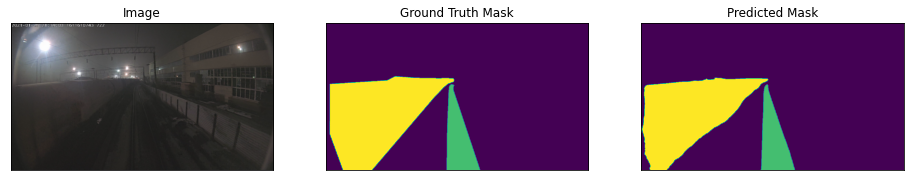

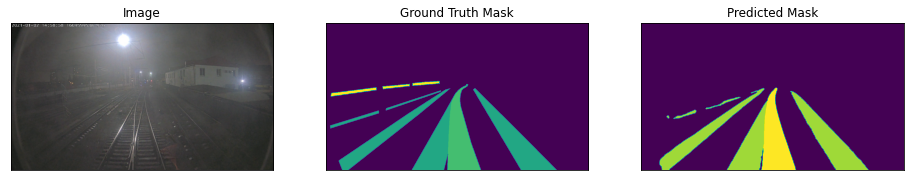

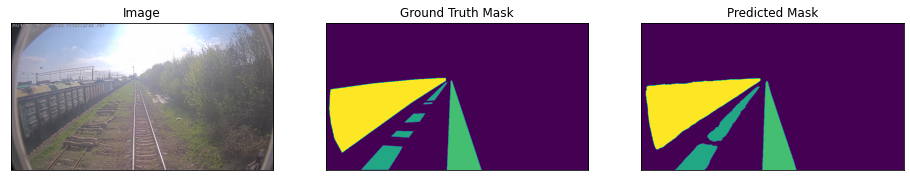

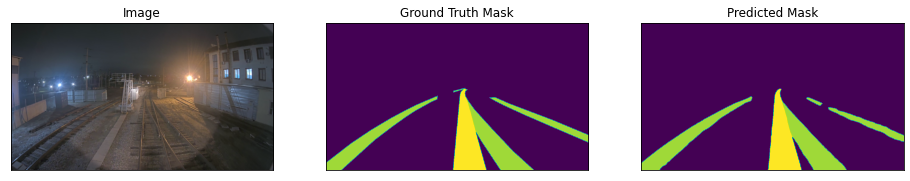

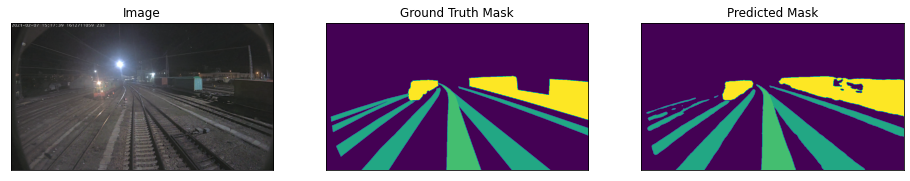

In [31]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    gt_mask_ = np.zeros((gt_mask.shape[1], gt_mask.shape[2]))
    gt_mask_ = np.where(gt_mask[0, ...] != 1, gt_mask_, 6)
    gt_mask_ = np.where(gt_mask[1, ...] != 1, gt_mask_, 7)
    gt_mask_ = np.where(gt_mask[2, ...] != 1, gt_mask_, 10)
    
    # x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    x_tensor = torch.from_numpy(image).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    pr_mask_ = np.zeros((pr_mask.shape[1], pr_mask.shape[2]))
    pr_mask_ = np.where(pr_mask[0, ...] != 1, pr_mask_, 6)
    pr_mask_ = np.where(pr_mask[1, ...] != 1, pr_mask_, 7)
    pr_mask_ = np.where(pr_mask[2, ...] != 1, pr_mask_, 10)
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask_, 
        predicted_mask=pr_mask_
    )

## Inference

In [52]:
x_test_files = glob('test_dataset_test/*')

for file in tqdm(x_test_files):

    image_vis = cv2.imread(file)
    xshape, yshape = image_vis.shape[0], image_vis.shape[1]
    image_vis = cv2.cvtColor(image_vis, cv2.COLOR_BGR2RGB)
    
    image_vis = cv2.resize(image_vis, (864, 576))
    
    image = to_tensor(preprocessing_fn(image_vis))
    
    x_tensor = torch.from_numpy(image).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor).squeeze().cpu().numpy()
    
    np.save('masks/model8/'+file.split('/')[-1], pr_mask)

100%|█████████████████████████████████████| 1000/1000 [1:27:30<00:00,  5.25s/it]


In [55]:
x_test_files = glob('test_dataset_test/*')

for file in tqdm(x_test_files):

    image_vis = cv2.imread(file)
    xshape, yshape = image_vis.shape[0], image_vis.shape[1]
    image_vis = cv2.cvtColor(image_vis, cv2.COLOR_BGR2RGB)
    
    image_vis = cv2.resize(image_vis, (1024, 576))
    
    image = to_tensor(preprocessing_fn(image_vis))
    
    x_tensor = torch.from_numpy(image).unsqueeze(0)
    pr_mask = best_model2.predict(x_tensor).squeeze().cpu().numpy()
    
    np.save('masks/model9/'+file.split('/')[-1], pr_mask)

 22%|████████▍                             | 221/1000 [21:28<1:15:41,  5.83s/it]


KeyboardInterrupt: 

In [69]:
image_vis.shape

(1512, 2688, 3)

In [120]:
x_test_files = glob('test_dataset_test/*')

for file in tqdm(x_test_files):

    image_vis = cv2.imread(file)
    xshape, yshape = image_vis.shape[0], image_vis.shape[1]
    image_vis = cv2.cvtColor(image_vis, cv2.COLOR_BGR2RGB)
    
    pr_mask_ = np.zeros((576, 864, 3))
    
    image = cv2.resize(image_vis, (864, 576))
    image = to_tensor(preprocessing_fn(image))
    x_tensor = torch.from_numpy(image).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor).squeeze().cpu().numpy()
    
    pr_mask_[..., 0] = pr_mask[0, ...] / 3
    pr_mask_[..., 1] = pr_mask[1, ...] / 3
    pr_mask_[..., 2] = pr_mask[2, ...] / 3
    
    pr_mask_ = cv2.resize(pr_mask_, (1024, 576))
    
    image = cv2.resize(image_vis, (1024, 576))
    image = to_tensor(preprocessing_fn(image))
    x_tensor = torch.from_numpy(image).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor).squeeze().cpu().numpy()
    
    pr_mask_[..., 0] += pr_mask[0, ...] / 3
    pr_mask_[..., 1] += pr_mask[1, ...] / 3
    pr_mask_[..., 2] += pr_mask[2, ...] / 3
    
    image = cv2.resize(image_vis, (1024, 576))
    image = to_tensor(preprocessing_fn(image))
    x_tensor = torch.from_numpy(image).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor).squeeze().cpu().numpy()
    
    pr_mask_[..., 0] += pr_mask[0, ...] / 3
    pr_mask_[..., 1] += pr_mask[1, ...] / 3
    pr_mask_[..., 2] += pr_mask[2, ...] / 3
    
    pr_mask_ = cv2.resize(pr_mask_, (yshape, xshape))
    
    _pr_mask_ = np.zeros((pr_mask_.shape[0], pr_mask_.shape[1]))
    _pr_mask_ = np.where(pr_mask_[..., 0] < 0.5, _pr_mask_, 6)
    _pr_mask_ = np.where(pr_mask_[..., 1] < 0.5, _pr_mask_, 7)
    _pr_mask_ = np.where(pr_mask_[..., 2] < 0.5, _pr_mask_, 10)
    _pr_mask_ = _pr_mask_.astype(np.uint8)
    
    # break
    
    cv2.imwrite('masks/'+file.split('/')[-1], _pr_mask_)
    

100%|█████████████████████████████████████| 1000/1000 [6:14:58<00:00, 22.50s/it]


In [118]:
pr_mask_.max()

0.9999725264402068

In [112]:
pr_mask.shape

(3, 576, 1024)

In [113]:
pr_mask_.shape

(1512, 2688, 3)

In [114]:
_pr_mask_.shape

(1512, 2688)

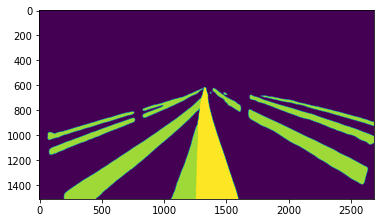

In [115]:
plt.imshow(_pr_mask_)

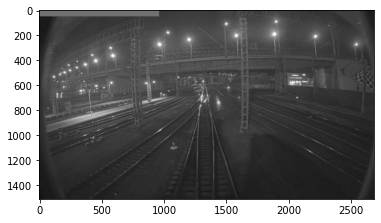

In [116]:
plt.imshow(image_vis)

In [37]:
x_test_files = glob('test_dataset_test/*')

for file in tqdm(x_test_files):

    image_vis = cv2.imread(file)
    xshape, yshape = image_vis.shape[0], image_vis.shape[1]
    image_vis = cv2.cvtColor(image_vis, cv2.COLOR_BGR2RGB)
    
    image_vis = cv2.resize(image_vis, (1024, 576))
    
    image = to_tensor(preprocessing_fn(image_vis))
    
    x_tensor = torch.from_numpy(image).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    pr_mask_changed = np.zeros((pr_mask.shape[1], pr_mask.shape[2], 3))
    pr_mask_changed[..., 0] = pr_mask[0, ...]
    pr_mask_changed[..., 1] = pr_mask[1, ...]
    pr_mask_changed[..., 2] = pr_mask[2, ...]
    pr_mask = pr_mask_changed
    
    pr_mask = cv2.resize(pr_mask, (yshape, xshape))
    
    pr_mask_ = np.zeros((pr_mask.shape[0], pr_mask.shape[1]))
    pr_mask_ = np.where(pr_mask[..., 0] != 1, pr_mask_, 6)
    pr_mask_ = np.where(pr_mask[..., 1] != 1, pr_mask_, 7)
    pr_mask_ = np.where(pr_mask[..., 2] != 1, pr_mask_, 10)
    pr_mask_ = pr_mask_.astype(np.uint8)
    
    cv2.imwrite('preds/'+file.split('/')[-1], pr_mask_)
    
    # break

100%|█████████████████████████████████████| 1000/1000 [2:40:18<00:00,  9.62s/it]


In [38]:
np.unique(pr_mask_)

array([0, 7], dtype=uint8)

In [39]:
pr_mask.shape

(2160, 3840, 3)

In [40]:
pr_mask_.shape

(2160, 3840)

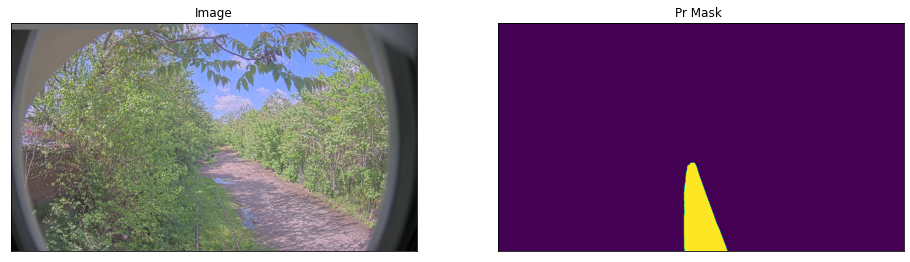

In [122]:
visualize(
        image=image_vis, 
        # predicted_mask=pr_mask,
        pr_mask_=_pr_mask_,
    )